In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [2]:
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

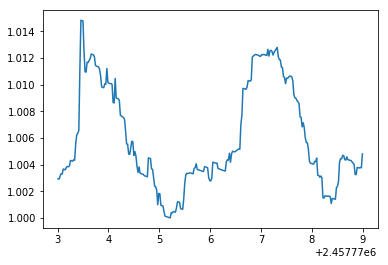

In [3]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 0)
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

plt.plot(k2_time, k2_flux)

std:  0.00118321694268
951 270


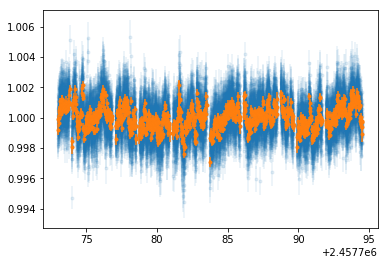

In [24]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_time_original = spitzer_time.copy()

spitzer_time += k2_time.min() - spitzer_time[0]
spitzer_flux += 1 - np.median(spitzer_flux)

spitzer_std = np.std(spitzer_flux)
print('std: ', spitzer_std)

from scipy.stats import binned_statistic

# Old spitzer bins on 1.8 rotations

# bins = np.arange(k2_time.min(), k2_time.max()+6*(k2_time[1]-k2_time[0]), k2_time[1]-k2_time[0])
# bs1 = binned_statistic(spitzer_time, spitzer_flux, statistic='mean', bins=bins)
# bs2 = binned_statistic(spitzer_time, spitzer_flux, statistic='std', bins=bins)
# bs3 = binned_statistic(spitzer_time, spitzer_err, statistic='mean', bins=bins)
# bs4 = binned_statistic(spitzer_time, spitzer_err, statistic='count', bins=bins)

# plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.1)

# bincenters = 0.5 * (bins[1:] + bins[:-1])

# spitzer_times = bincenters
# spitzer_fluxes = bs1.statistic
# spitzer_errors = bs3.statistic / np.sqrt(bs4.statistic)

# spitzer_times = spitzer_times[~np.isnan(spitzer_fluxes)]
# spitzer_errors = spitzer_errors[~np.isnan(spitzer_fluxes)]
# spitzer_fluxes = spitzer_fluxes[~np.isnan(spitzer_fluxes)]

# plt.errorbar(spitzer_times, spitzer_fluxes, spitzer_errors, fmt='.', zorder=100)
# print(len(spitzer_times), len(k2_time))

# New spitzer bins 
#bins = np.arange(k2_time.min(), k2_time.max()+6*(k2_time[1]-k2_time[0]), k2_time[1]-k2_time[0])

k2_cadence = (k2_time[1]-k2_time[0])
n_bins = spitzer_time.ptp()/k2_cadence
bins = np.arange(spitzer_time.min() - k2_cadence/2, spitzer_time.max() + k2_cadence, k2_time[1]-k2_time[0])
bs1 = binned_statistic(spitzer_time, spitzer_flux, statistic='mean', bins=bins)
bs2 = binned_statistic(spitzer_time, spitzer_flux, statistic='std', bins=bins)
bs3 = binned_statistic(spitzer_time, spitzer_err, statistic='mean', bins=bins)
bs4 = binned_statistic(spitzer_time, spitzer_err, statistic='count', bins=bins)

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.1)

bincenters = 0.5 * (bins[1:] + bins[:-1])

spitzer_times = bincenters
spitzer_fluxes = bs1.statistic
spitzer_errors = bs3.statistic / np.sqrt(bs4.statistic)

spitzer_times = spitzer_times[~np.isnan(spitzer_fluxes)]
spitzer_errors = spitzer_errors[~np.isnan(spitzer_fluxes)]
spitzer_fluxes = spitzer_fluxes[~np.isnan(spitzer_fluxes)]

plt.errorbar(spitzer_times, spitzer_fluxes, spitzer_errors, fmt='.', zorder=100)
print(len(spitzer_times), len(k2_time))

In [25]:
spitzer_time_original

array([  0.848934,   0.850399,   0.851863, ...,  22.352352,  22.353816,
        22.355281])

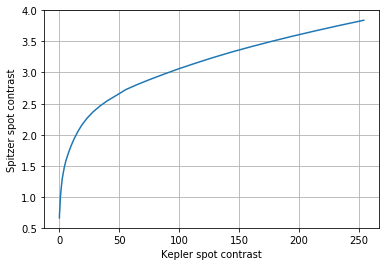

In [18]:
kepler_contrast, spitzer_contrast = np.loadtxt('kepler_to_spitzer_contrast.txt', unpack=True)

def kepler_to_spitzer_contrast_interp(contrast):
    return np.interp(contrast, kepler_contrast, spitzer_contrast)

plt.plot(kepler_contrast, spitzer_contrast)
plt.grid()
plt.xlabel('Kepler spot contrast')
plt.ylabel('Spitzer spot contrast')
plt.savefig('kepler_spitzer_contrasts.png', dpi=200)

In [6]:
# plt.plot(kepler_contrast_range, spitzer_contrast_range)
# contrast_p = np.polyfit(kepler_contrast_range, spitzer_contrast_range, 10)

# contrast_p = np.array([ -2.86673787e+00,   3.04324483e+01,  -1.39102663e+02,
#                          3.58168264e+02,  -5.70729646e+02,   5.82371946e+02,
#                         -3.80959509e+02,   1.55908866e+02,  -3.81530016e+01,
#                          5.54607524e+00,   3.85779028e-01])

# def kepler_to_spitzer_contrast_interp(kepler_contrast):
#     return np.polyval(contrast_p, kepler_contrast)

# plt.plot(kepler_contrast_range, np.polyval(contrast_p, kepler_contrast_range), ls='--')
# plt.xlabel('kepler contrast')
# plt.ylabel('spitzer contrast')
# plt.grid()

In [13]:
from scipy.interpolate import interp2d
# spot_temperatures, spotted_areas ,i_minus_j = [i[1] for i in np.load('color_grid.npz').items()]
# interpolate_color = interp2d(spot_temperatures, spotted_areas, i_minus_j)

temperature_grid, area_grid, probability_grid = [i[1] for i in np.load('color_probability_grid.npz').items()]
interpolate_color_probability = interp2d(area_grid, temperature_grid, probability_grid)

In [14]:
interpolate_color_probability(0.000000001, 5000)

array([ 0.99999993])

In [15]:
kepler_contrasts, spot_temperatures = np.loadtxt('contrast_to_temperature.txt', unpack=True)
interpolate_contrast_to_temperature = lambda x: np.interp(x, kepler_contrasts, spot_temperatures)

In [16]:
interpolate_contrast_to_temperature(600)

6646.680107670456

In [10]:
def model(p, kepler_time, spitzer_time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kepler_contrast, kep_offset = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day, u1=1.00, u2=-0.04)
    kepler_model_flux = kepler_star.flux(kepler_time)
    norm_factor = np.min(kepler_model_flux)
    kepler_model_flux /= norm_factor
    kepler_model_flux += kep_offset
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    #print(spitzer_contrast / kepler_contrast)
#     spitzer_model_flux = (kepler_model_flux - 1) * spitzer_contrast / kepler_contrast + 1
#     spitzer_model_flux /= np.median(spitzer_model_flux)

    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=spitzer_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=spitzer_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=spitzer_contrast)]

    spitzer_star = Star(spots=spots, rotation_period=3.3*u.day, u1=1.00, u2=-0.04)
    spitzer_model_flux = spitzer_star.flux(spitzer_time)
    spitzer_model_flux /= np.median(spitzer_model_flux)

    return kepler_model_flux, spitzer_model_flux

def chi2(p, kepler_time, spitzer_time):
    kepler_model_flux, model_spitzer_flux = model(p, kepler_time, spitzer_time)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast, kep_offset = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
    # Bright Spot initial conditions
    if not (300 < lon0 < 360 and 30 < lon1 < 70 and 190 < lon2 < 280):
        return -np.inf
    if not (1 < contrast < 600):
        return -np.inf
    if not (-1 < kep_offset < 1):
        return -np.inf
    
    trappist1_v_minus_i = 4.7323
    # Limit color variations
    temperature = interpolate_contrast_to_temperature(contrast)
    minimum_radius = np.min(rads)
    spotted_area = minimum_radius**2 
    lnprob = np.log(interpolate_color_probability(spotted_area, temperature))
    return lnprob

def lnprob(p, kepler_time, spitzer_time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, kepler_time, spitzer_time)

initp = np.array([0, 330, 0.02, 
                  0,  50, 0.008, 
                  0, 210, 0.008, 20, 0])
ndim, nwalkers = 11, 40
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

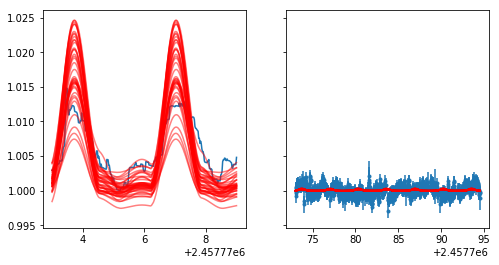

In [125]:
initp = np.array([0, 330, 0.008, 
                  0,  50, 0.002, 
                  0, 210, 0.002, 180, 0])
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].plot(k2_time, k2_flux)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*3, fmt='.')
for p in pos:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time, spitzer_times)
    ax[0].plot(k2_time, model_k2_fluxes, color='r', alpha=0.5)
    ax[1].plot(spitzer_times, model_spitzer_flux, color='r', alpha=0.5, zorder=10)
    #print(model_spitzer_std, spitzer_std)

In [126]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, spitzer_times), 
                                threads=8)
sampler.run_mcmc(pos, 5000);

In [127]:
#n_burnin = 200
n_burnin = 1000
samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
# samples = sampler.flatchain

In [128]:
np.savetxt('posteriors_bright_spot.txt', samples)

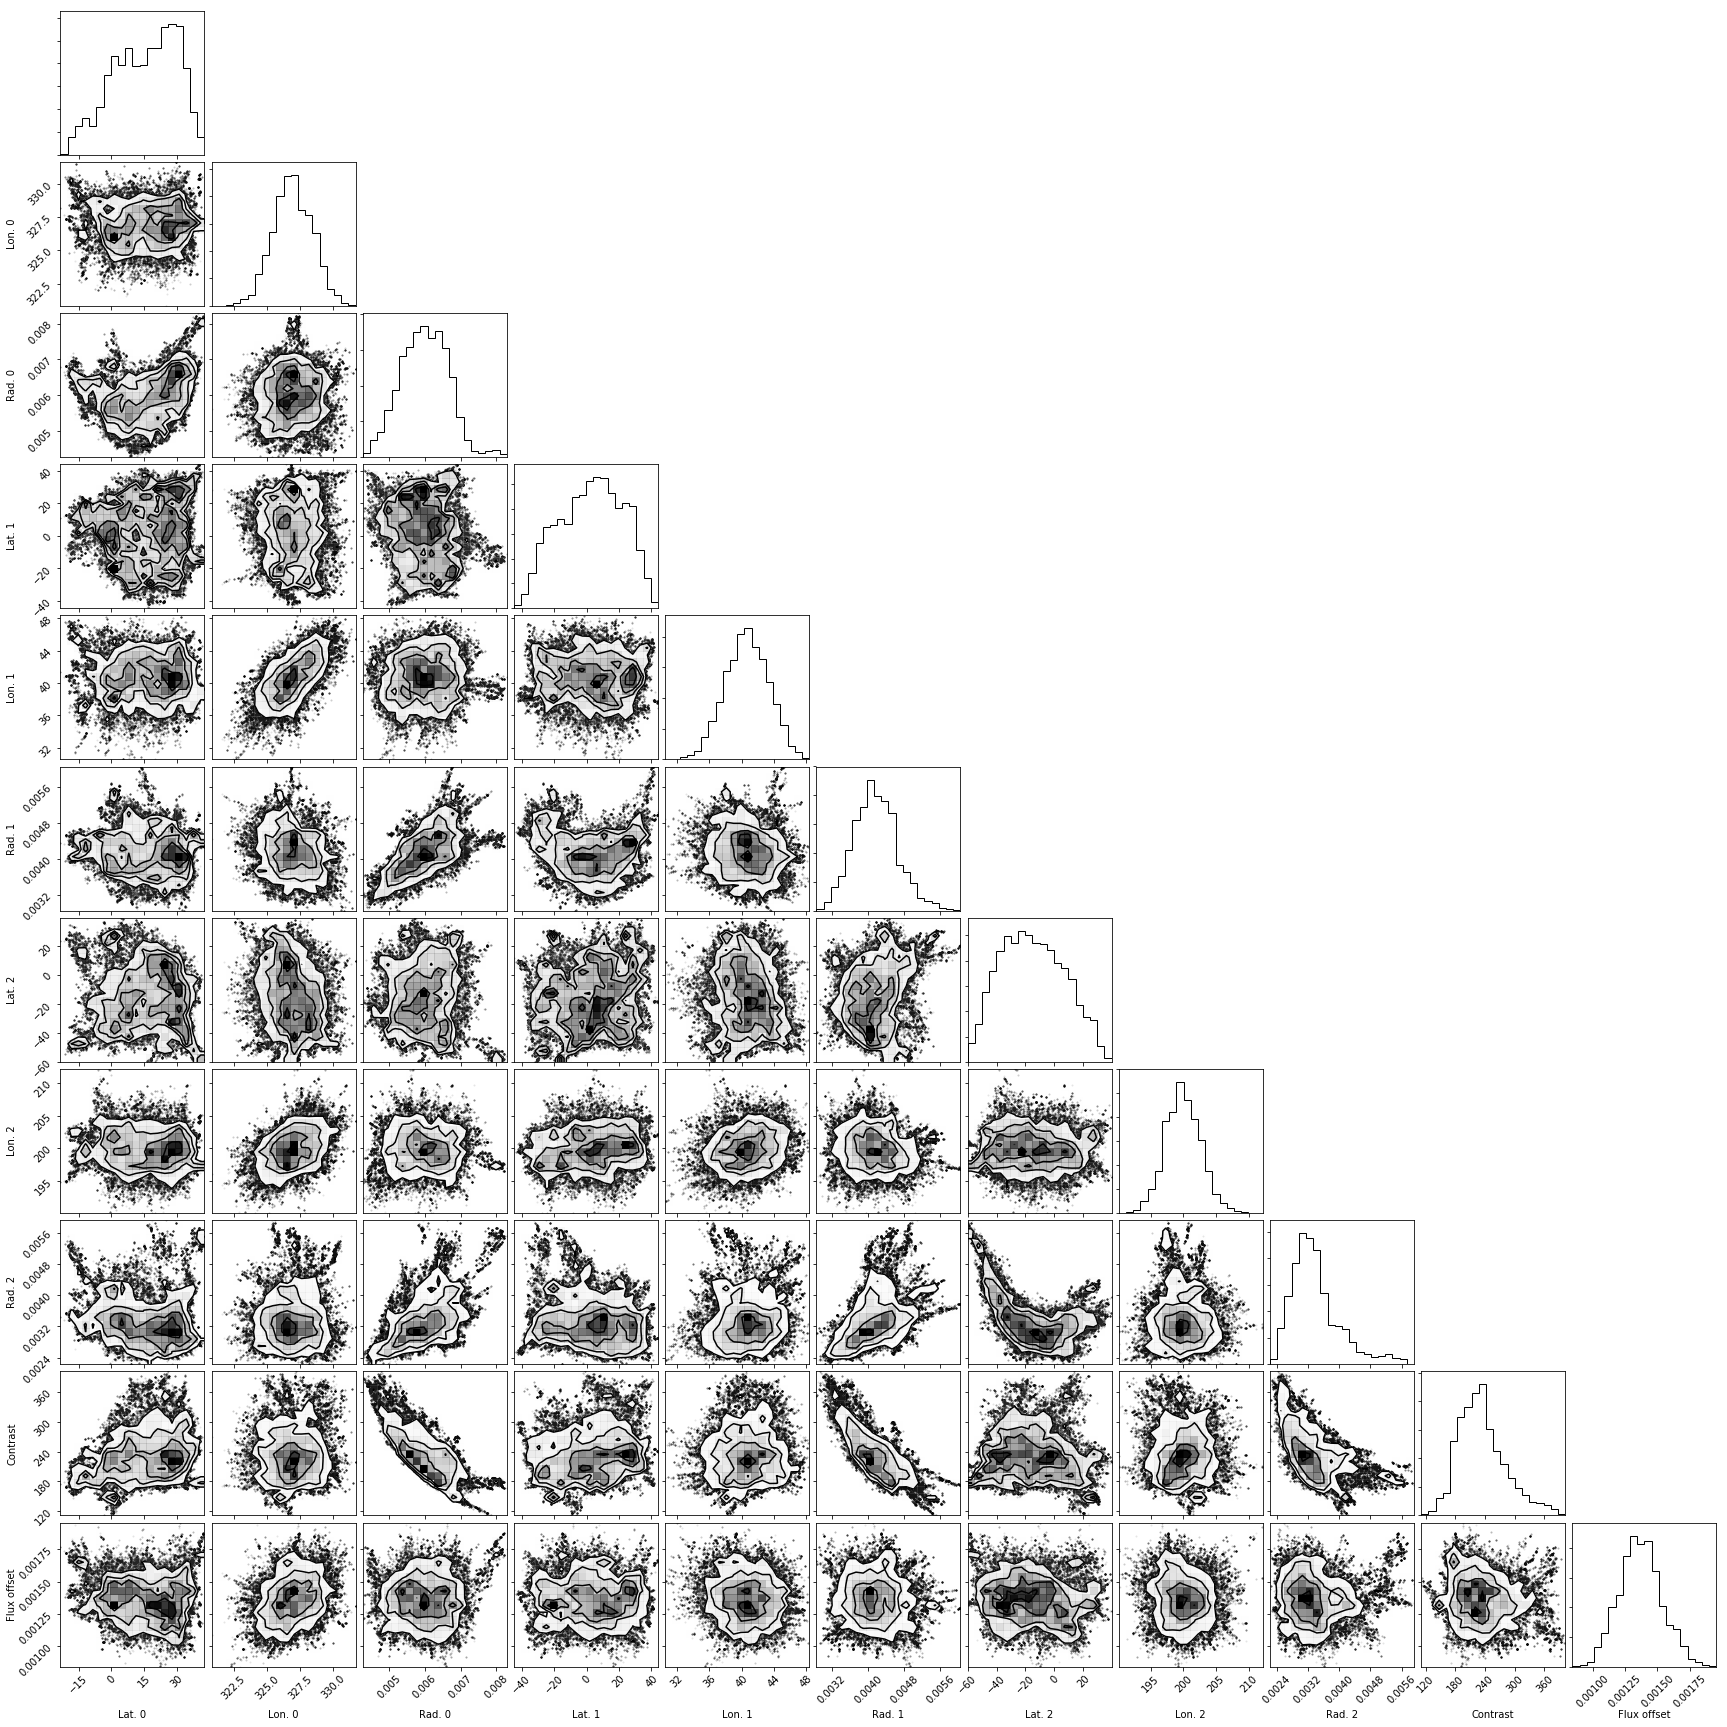

In [129]:
labels = ['Lat. 0', 'Lon. 0', 'Rad. 0', 'Lat. 1', 'Lon. 1', 'Rad. 1', 
          'Lat. 2', 'Lon. 2', 'Rad. 2', 'Contrast', 'Flux offset']
from corner import corner

corner(samples, labels=labels)

plt.savefig('corner_bright_spitzer.png', bbox_inches='tight', dpi=250)
plt.savefig('corner_bright_spitzer.pdf', bbox_inches='tight')
plt.show()

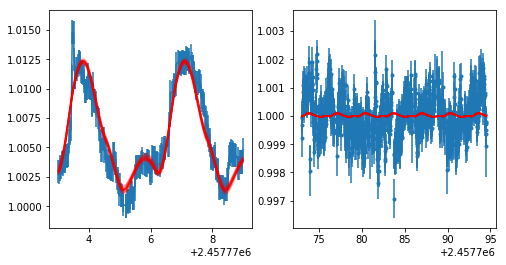

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.')
for p in samples[np.random.randint(0, samples.shape[0], 50), :]:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time, spitzer_times)
    ax[0].plot(k2_time, model_k2_fluxes, alpha=0.1, color='r', zorder=10)
    ax[1].plot(spitzer_times, model_spitzer_flux, alpha=0.1, color='r', zorder=10)
    #print(model_spitzer_std, spitzer_std)

In [5]:
samples = np.loadtxt('posteriors_bright_spot.txt')

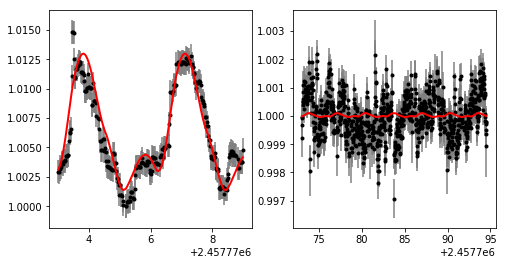

In [19]:
#best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]
best_params = np.median(samples, axis=0)
best_model_k2, best_model_sp = model(best_params, k2_time, spitzer_time)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray')
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.', color='k', ecolor='gray')

ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2)
ax[1].plot(spitzer_time, best_model_sp, color='r', zorder=10, lw=2)

In [20]:
#extended_model_k2, extended_model_sp = model(best_params, spitzer_time)


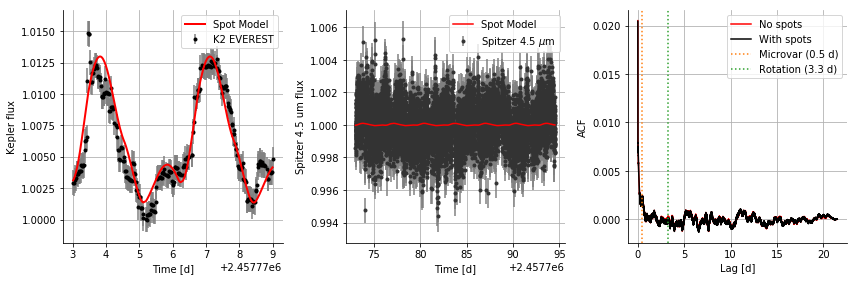

In [21]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux + (best_model_sp - 1) - 1)

lag_nospots, acf_nospots = interpolated_acf(spitzer_time, spitzer_flux - 1)

best_period = dominant_period(lag, acf)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].errorbar(k2_time, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray', label='K2 EVEREST')
ax[0].plot(k2_time, best_model_k2, color='r', zorder=10, lw=2, label='Spot Model')
ax[0].set(xlabel='Time [d]', ylabel='Kepler flux')
ax[0].legend()

ax[1].errorbar(spitzer_time, spitzer_flux, spitzer_err, label='Spitzer 4.5 $\mu$m', fmt='.', color='#333333', ecolor='gray')
ax[1].plot(spitzer_time, best_model_sp, label='Spot Model', color='r', zorder=10)
ax[1].legend()

ax[2].plot(lag_nospots, acf_nospots, color='r', label='No spots')
ax[2].plot(lag, acf, color='k', label='With spots')

ax[2].set_xlabel('Lag [d]')
ax[2].set_ylabel('ACF')
ax[1].set(xlabel='Time [d]', ylabel='Spitzer 4.5 um flux')
ax[2].axvline(0.5, ls=':', color='C1', label='Microvar (0.5 d)')
ax[2].axvline(3.3, ls=':', color='C2', label='Rotation (3.3 d)')
ax[2].legend()

for axis in ax: 
    axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('best_bright_spot_model.png', bbox_inches='tight', dpi=250)
fig.savefig('best_bright_spot_model.pdf', bbox_inches='tight')

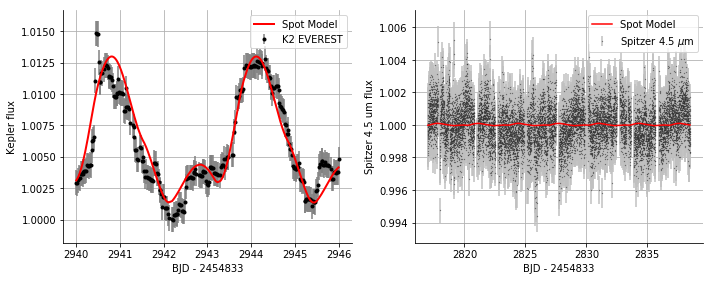

In [37]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux + (best_model_sp - 1) - 1)

lag_nospots, acf_nospots = interpolated_acf(spitzer_time, spitzer_flux - 1)

best_period = dominant_period(lag, acf)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

bjd_offset = 2454833
actual_spitzer_t0 = 7650 + 2450000

ax[0].errorbar(k2_time - bjd_offset, k2_flux, 2*k2_err, fmt='.', color='k', ecolor='gray', label='K2 EVEREST')
ax[0].plot(k2_time - bjd_offset, best_model_k2, color='r', zorder=10, lw=2, label='Spot Model')
ax[0].set(xlabel='BJD - 2454833', ylabel='Kepler flux')
ax[0].legend()

ax[1].errorbar(spitzer_time - k2_time.min() + actual_spitzer_t0 - bjd_offset, spitzer_flux, spitzer_err, label='Spitzer 4.5 $\mu$m', 
               fmt='.', color='#333333', ecolor='silver', ms=0.5)
ax[1].plot(spitzer_time - k2_time.min() + actual_spitzer_t0 - bjd_offset, best_model_sp, label='Spot Model', color='r', zorder=10)
ax[1].legend()
ax[1].set(xlabel='BJD - 2454833', ylabel='Spitzer 4.5 um flux')

for axis in ax: 
    axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('best_bright_spot_model.png', bbox_inches='tight', dpi=250)
fig.savefig('best_bright_spot_model.pdf', bbox_inches='tight')

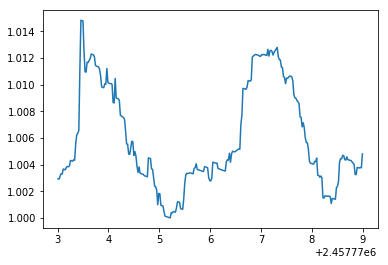

In [38]:
plt.plot(k2_time, k2_flux)

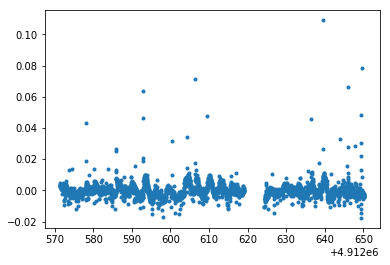

In [57]:
from astropy.utils.data import download_file
from astropy.io import fits
from scipy.signal import medfilt

p = download_file('https://github.com/rodluger/trappist1/raw/master/output/nPLDTrappist.fits', cache=True)
f = fits.getdata(p)
bjd_offset = 2454833.0
not_nans = ~np.isnan(f['FLUX'])
time = f['TIME'][not_nans] + bjd_offset
flux = f['FLUX'][not_nans] / np.median(f['FLUX'][not_nans])

condition = (flux > 0.95) & (flux < 1.2) 

plt.figure()

filtered_time = time[condition] + bjd_offset
# Smooth the TRAPPIST-1 LC over only 50 fluxes
#filtered_flux = medfilt(flux[condition], (51), )

# Remove quadratic

p = np.polyfit((filtered_time - filtered_time.mean()), flux[condition], 5)
fit = np.polyval(p, (filtered_time - filtered_time.mean()))

filtered_flux = flux[condition] - fit 

trappist1 = [filtered_time, flux[condition]/np.median(flux[condition]) - 1]

#lag_k2, acf_k2 = interpolated_acf(filtered_time, filtered_flux/np.median(filtered_flux) - 1)

lag_k2, acf_k2 = interpolated_acf(filtered_time, filtered_flux)

plt.plot(filtered_time, filtered_flux, '.')

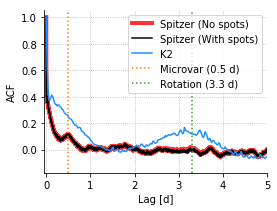

In [59]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(lag_nospots, acf_nospots/acf_nospots.max(), color='r', lw=4, alpha=0.8, label='Spitzer (No spots)')
ax.plot(lag, acf/acf.max(), color='k', label='Spitzer (With spots)')

ax.plot(lag_k2, acf_k2/acf_k2.max(), color='DodgerBlue', label='K2')


ax.set_xlabel('Lag [d]')
ax.set_ylabel('ACF')
ax.axvline(0.5, ls=':', color='C1', label='Microvar (0.5 d)')
ax.axvline(3.3, ls=':', color='C2', label='Rotation (3.3 d)')
ax.legend()
ax.grid(ls=':')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([-0.05, 5])
fig.savefig('acf_sanity.pdf', bbox_inches='tight')

Spot radii: 

In [141]:
np.median(samples[:, 2::3], axis=0), np.std(samples[:, 2::3], axis=0)

(array([ 0.0059925 ,  0.00414219,  0.00327107]),
 array([ 0.00065932,  0.00048319,  0.00063222]))

Spot contrast in the kepler band

In [142]:
np.median(samples[:, -2]), np.std(samples[:, -2])

(228.27473440801637, 48.202953296259345)

spot contrast in the spitzer band

In [143]:
spitz_contrast = kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]))
plus_minus = kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]) + np.std(samples[:, -2]))

print(spitz_contrast, plus_minus - spitz_contrast)

3.7330477915041715 0.10688379377466406


Total spot coverage

In [146]:
np.sum(np.pi * np.median(samples[:, 2::3], axis=0)**2 / (4 * np.pi))

1.5941931919359189e-05

In [147]:
typical_spot_radius = np.median(np.median(samples[:, 2::3], axis=0))

typical_spot_radius_err = np.median(np.std(samples[:, 2::3], axis=0))

typical_spot_contrast_kepler = np.median(samples[:, -2])

typical_spot_contrast_kepler_err = np.std(samples[:, -2])

typical_spot_contrast_spitzer = kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]))

typical_spot_contrast_err = kepler_to_spitzer_contrast_interp(np.median(samples[:, -2]) + np.std(samples[:, -2])) - typical_spot_contrast_spitzer


print(typical_spot_radius, typical_spot_contrast_kepler)

contamination_kepler = 1 + typical_spot_contrast_kepler * typical_spot_radius**2

contamination_kepler_error = np.sqrt( (typical_spot_radius**2 * typical_spot_contrast_kepler_err)**2 + 
                                      (2 * (typical_spot_contrast_kepler - 1)*typical_spot_radius*typical_spot_radius_err)**2 )

contamination_spitzer = 1 + typical_spot_contrast_spitzer * typical_spot_radius**2

contamination_spitzer_error = np.sqrt( (typical_spot_radius**2 * typical_spot_contrast_err)**2 + 
                                      (2 * (typical_spot_contrast_spitzer - 1)*typical_spot_radius*typical_spot_radius_err)**2 )



print(contamination_kepler, contamination_kepler_error)
print(contamination_spitzer, contamination_spitzer_error)
#contamination_spitzer

0.00414219013748 228.274734408
1.00391667834 0.00144948240891
1.00006405066 1.44315590009e-05


In [148]:
from astropy.constants import R_sun, R_earth, M_earth

R_star = 0.117 * R_sun

(typical_spot_radius * R_star).to(u.km)

<Quantity 337.16143640161374 km>

In [149]:
from libra import trappist1

rps = [trappist1(p).rp for p in list('bcdefgh')]

In [150]:

old_depths = np.array([[0.7266, 0.0088], [0.687, 0.010], [0.367, 0.017], [0.519, 0.026], 
                       [0.673, 0.023], [0.782, 0.027], [0.352, 0.0326]]) / 100

sigma_R_star = 0.0036 * R_sun
new_depths = old_depths * contamination_kepler

old_radii = np.array([[1.086,  0.035], [1.056,  0.035], [0.772,  0.030], [0.918,  0.039], 
                      [1.045,  0.038], [1.127, 0.041], [0.755,  0.034]])

masses = np.array([[0.85, 0.72], [1.38, 0.61], [0.41, 0.27], [0.62, 0.58], 
                   [0.68, 0.18], [1.34, 0.88], [1.0, 1.0]])

old_densities = np.array([[0.66,0.56], [1.17, 0.53], [0.89, 0.60], [0.80, 0.76],
                          [0.60,  0.17], [0.94,  0.63], [1.0, 1.0]])

new_radii = ((np.sqrt(new_depths[:, 0]) * R_star / R_earth).decompose()).value
new_radii_errors = (((np.sqrt((0.5 * R_star/ np.sqrt(new_depths[:, 0]) * new_depths[:, 1])**2 + 
                           (np.sqrt(new_depths[:, 0]) * sigma_R_star)**2 )) ) / R_earth).decompose().value

new_radii = np.vstack([new_radii, new_radii_errors]).T

new_densities = masses[:, 0] * M_earth /(4/3 * np.pi * (new_radii[:, 0] * R_earth)**3)
new_densities_errors = np.sqrt( (masses[:, 1] * M_earth/(4/3 * np.pi * (new_radii[:, 0] * R_earth)**3))**2 + 
                                ((new_radii[:, 1] * R_earth * masses[:, 1] * M_earth) / 
                                 (4 * np.pi * (new_radii[:, 0] * R_earth)**4))**2 ) 

density_earth = M_earth / (4/3 * np.pi * R_earth**3)

new_densities = (np.vstack([new_densities, new_densities_errors]).T  / density_earth).value

In [151]:
new_densities

array([[ 0.65641683,  0.55605405],
       [ 1.15917192,  0.51241605],
       [ 0.88204072,  0.58090394],
       [ 0.79313027,  0.74202546],
       [ 0.58910158,  0.15594939],
       [ 0.92682671,  0.60870441],
       [ 2.29028684,  2.29068011]])

In [152]:
from astropy.table import Table


def formatter(array):
    formatted = []
    for row in array: 
        formatted.append(r"${0:.3f} \pm {1:.3f}$".format(row[0], row[1]))
    return formatted

columns = [list('bcdefgh'), formatter(old_depths*100), formatter(new_depths*100), formatter(old_radii), 
           formatter(new_radii), formatter(old_densities), formatter(new_densities)]
names = ["Planet", "Gillon+ (2017) Depth", "Depth (this work)", "Gillon+ (2017) Radii", 
         "Radii (this work)", "Gillon+ (2017) Densities", "Densities (this work)"]
table = Table(columns, names=names)

ascii.write(table, format='latex')

\begin{table}
\begin{tabular}{ccccccc}
Planet & Gillon+ (2017) Depth & Depth (this work) & Gillon+ (2017) Radii & Radii (this work) & Gillon+ (2017) Densities & Densities (this work) \\
b & $0.727 \pm 0.009$ & $0.729 \pm 0.009$ & $1.086 \pm 0.035$ & $1.090 \pm 0.034$ & $0.660 \pm 0.560$ & $0.656 \pm 0.556$ \\
c & $0.687 \pm 0.010$ & $0.690 \pm 0.010$ & $1.056 \pm 0.035$ & $1.060 \pm 0.034$ & $1.170 \pm 0.530$ & $1.159 \pm 0.512$ \\
d & $0.367 \pm 0.017$ & $0.368 \pm 0.017$ & $0.772 \pm 0.030$ & $0.775 \pm 0.030$ & $0.890 \pm 0.600$ & $0.882 \pm 0.581$ \\
e & $0.519 \pm 0.026$ & $0.521 \pm 0.026$ & $0.918 \pm 0.039$ & $0.921 \pm 0.037$ & $0.800 \pm 0.760$ & $0.793 \pm 0.742$ \\
f & $0.673 \pm 0.023$ & $0.676 \pm 0.023$ & $1.045 \pm 0.038$ & $1.049 \pm 0.037$ & $0.600 \pm 0.170$ & $0.589 \pm 0.156$ \\
g & $0.782 \pm 0.027$ & $0.785 \pm 0.027$ & $1.127 \pm 0.041$ & $1.131 \pm 0.040$ & $0.940 \pm 0.630$ & $0.927 \pm 0.609$ \\
h & $0.352 \pm 0.033$ & $0.353 \pm 0.033$ & $0.755 \pm 0.034$ & 

In [153]:
temperature_samples = interpolate_contrast_to_temperature(samples[:, -2])

lower, mid, upper = np.percentile(temperature_samples, [16, 50, 84])

err_lower = lower - mid
err_upper = upper - mid

print("{0:.0f}^{{+{1:.0f}}}_{{{2:.0f}}}".format(mid, err_upper, err_lower))

5276^{+249}_{-213}


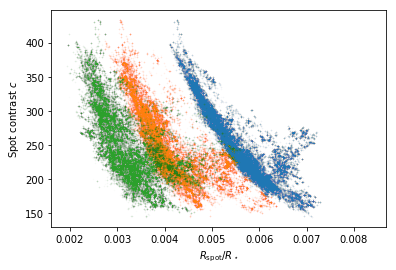

In [96]:
radii = samples[:, 2::3]
contrasts = samples[:, -2]

for rad in radii.T: 
    plt.scatter(rad, contrasts, s=1, alpha=0.01)
    
plt.xlabel('$R_\mathrm{spot}/R_\star$')
plt.ylabel('Spot contrast $c$')
plt.savefig('radius_contrast.png', bbox_inches='tight', dpi=200)

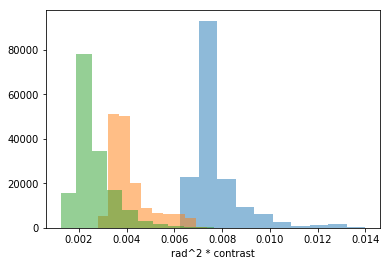

In [97]:
for rad in radii.T: 
    plt.hist(rad**2 * contrasts, alpha=0.5)
plt.xlabel('rad^2 * contrast')
plt.savefig('rad2_contrast.png')

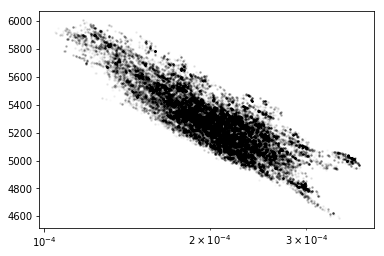

In [166]:
temperature_samples = interpolate_contrast_to_temperature(samples[:, -2])
area_samples = np.sum(np.pi*samples[:, 2::3]**2, axis=1)
plt.plot(area_samples, temperature_samples, '.k', alpha=0.01, ms=3)
plt.xscale('log')